# Library

In [30]:
pip install selectivesearch

Note: you may need to restart the kernel to use updated packages.


In [31]:
# Librerie standard
import os
import random
import time
import re
from pathlib import Path
from collections import defaultdict, Counter
from itertools import islice

# Librerie per il trattamento delle immagini
import cv2
import imageio.v3 as imageio
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from torchvision.transforms import functional as TF

# Librerie per il machine learning e deep learning
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as func
import torchvision.models as models
from sklearn.svm import SVC

# Librerie per la gestione dei dati
import pandas as pd
import json
import orjson
import shutil 

# Librerie per il parallelismo e il multiprocessing
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor

# Librerie per l'ottimizzazione e la gestione delle dipendenze
import selectivesearch

# Librerie per il progresso e il monitoraggio
from tqdm import tqdm

# Librerie per la gestione dei dataset
from torch.utils.data import Dataset, DataLoader

# Librerie per modelli e trasformazioni in PyTorch
from torchvision import transforms

from collections import Counter
from sklearn.model_selection import train_test_split


# Path

In [32]:
#Output folders and file names
COCO_JSON_NM = 'COCO_annotations_new.json'
OUT_COCO_JSON_NM = 'mod_COCO_annotations.json'
OUT_IMAGE_FLDR_NM = 'images'
OUT_CFG_FLDR_NM = 'YOLO_cfg'
RANDOM_SEED = 2023

in_dataset_pth = Path('/kaggle/input/our-xview-dataset')
out_dataset_pth = Path('/kaggle/working/')
img_fldr = Path(f'/kaggle/input/our-xview-dataset/{OUT_IMAGE_FLDR_NM}')
cfg_fldr_pth = Path(f'/kaggle/input/our-xview-dataset/{OUT_CFG_FLDR_NM}')

coco_json_pth = in_dataset_pth / COCO_JSON_NM
new_coco_json_pth = out_dataset_pth / OUT_COCO_JSON_NM
train_txt_pth = cfg_fldr_pth / 'train.txt'
val_txt_pth = cfg_fldr_pth / 'val.txt'
test_txt_pth = cfg_fldr_pth / 'test.txt'

# PROPOSALS
OUT_PROPOSALS_FLDR_NM = 'proposals'
prop_fldr = Path(f'/kaggle/working/{OUT_PROPOSALS_FLDR_NM}')
PROP_COCO_JSON_NM = 'proposals.json'
proposals_json = out_dataset_pth / PROP_COCO_JSON_NM
ACTPROP_COCO_JSON_NM ='active_regions.json'
actproposals_json = out_dataset_pth / ACTPROP_COCO_JSON_NM
ACTPROP_WEIG_COCO_JSON_NM ='active_regions_weights.json'
actproposalsweights_json = out_dataset_pth / ACTPROP_WEIG_COCO_JSON_NM

# ACTIVE REGIONS
act_reg_path = Path('/kaggle/input/activeregion-xviewdataset')
act_reg_folder = Path('/kaggle/input/activeregion-xviewdataset/activeregion-xview-dataset/proposals')

#DATASET
train_path = '/kaggle/working/train.json'
test_path = '/kaggle/working/test.json'
val_path = '/kaggle/working/val.json'

random.seed(RANDOM_SEED)

In [33]:
# Pulizia dell'output per cartelle specifiche
def clean_output(output_dir):
    if output_dir.exists() and output_dir.is_dir():
        for item in output_dir.iterdir():
            if item.is_dir():
                shutil.rmtree(item)  # Rimuove la sotto-cartella
            else:
                item.unlink()  # Rimuove il file
        print(f"Cartella {output_dir} pulita.")
    else:
        print(f"Cartella {output_dir} non trovata. Nessuna azione necessaria.")

# Pulisce la cartella di output prima di avviare il processo
clean_output(out_dataset_pth)
clean_output(prop_fldr)

Cartella /kaggle/working pulita.
Cartella /kaggle/working/proposals non trovata. Nessuna azione necessaria.


# Utility

In [34]:
import warnings

# Sopprime i warning specifici del modulo skimage
warnings.filterwarnings("ignore", 
    message="Applying `local_binary_pattern` to floating-point images may give unexpected results.*")

In [ ]:
def load_json(file_path):
    """
    Carica un file JSON dal percorso specificato.

    :param file_path: Percorso al file JSON da caricare.
    :return: Dati contenuti nel file JSON (come dizionario o lista).
    """
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

# COCO Preprocessing

In [35]:
def process_custom_coco_json(input_path, output_path):
    """
    Funzione per processare un JSON COCO in formato personalizzato.
    """
    # Leggi il JSON dal file di input
    data = load_json(input_path)

    # Ottieni e correggi il formato delle categorie
    raw_categories = data.get('categories', [])
    categories = []
 
    for category in tqdm(raw_categories, desc="Processing Categories"):
        for id_str, name in category.items():
            try:
                categories.append({"id": int(id_str), "name": name})
            except ValueError:
                print(f"Errore nel parsing della categoria: {category}")
 
    # Trova la categoria "Aircraft" con ID 0
    aircraft_category = next((cat for cat in categories if cat['id'] == 0 and cat['name'] == "Aircraft"), None)
    if aircraft_category:
        aircraft_category['id'] = 11  # Cambia l'ID della categoria "Aircraft" a 11
 
    # Aggiungi la categoria "background" con ID 0 se non esiste
    if not any(cat['id'] == 0 for cat in categories):
        categories.append({"id": 0, "name": "background"})
 
    # Preprocessa le annotazioni in un dizionario per immagini
    image_annotations_dict = {}
    for annotation in tqdm(data.get('annotations', []), desc="Building Image Annotations Dictionary"):
        image_id = annotation['image_id']
        if image_id not in image_annotations_dict:
            image_annotations_dict[image_id] = []
        image_annotations_dict[image_id].append(annotation)
 
    # Lista di nuove annotazioni da aggiungere per immagini senza bbox
    new_annotations = []
 
    # Elenco di annotazioni da rimuovere
    annotations_to_remove = []
 
    for annotation in tqdm(data.get('annotations', []), desc="Processing Annotations"):
        if annotation['category_id'] == 0:  # Se è Aircraft
            annotation['category_id'] = 11
        # Converte il formato del bbox
        if isinstance(annotation['bbox'], str):
            annotation['bbox'] = json.loads(annotation['bbox'])
        x, y, width, height = annotation['bbox']
        xmin = x
        xmax = x + width
        ymin = y
        ymax = y + height
        # Verifica che xmin < xmax e ymin < ymax
        if xmin >= xmax or ymin >= ymax:
            annotations_to_remove.append(annotation['id'])
        else:
            annotation['bbox'] = [xmin, xmax, ymin, ymax]
 
    # Rimuovi le annotazioni non valide
    data['annotations'] = [ann for ann in data['annotations'] if ann['id'] not in annotations_to_remove]
 
    # Verifica se ci sono immagini senza annotazioni (usando il dizionario delle annotazioni)
    for image in tqdm(data.get('images', []), desc="Processing Images"):
        if image['id'] not in image_annotations_dict:  # Se l'immagine non ha annotazioni
            # Aggiungi la categoria "background"
            new_annotation = {
                'id': len(data['annotations']) + len(new_annotations),
                'image_id': image['id'],
                'category_id': 0,  # Categoria background con ID 0
                'area': image['width'] * image['height'],
                'bbox': [0.0, image['width'], 0.0, image['height']],  # Background con bbox che copre tutta l'immagine
                'iscrowd': 0
            }
            new_annotations.append(new_annotation)
 
    # Aggiungi le nuove annotazioni al JSON originale
    data['annotations'].extend(new_annotations)
 
    # Aggiorna le categorie nel JSON
    data['categories'] = categories
 
    # Scrivi il JSON modificato nel file di output
    with open(output_path, 'w') as f:
        json.dump(data, f, indent=4)

In [36]:
process_custom_coco_json(coco_json_pth, new_coco_json_pth)

Processing Images: 100%|██████████| 45891/45891 [00:00<00:00, 560428.37it/s]


## Category Check

In [37]:
def count_bounding_boxes(json_path):
    """
    Conta il numero di bounding box per ogni categoria in un file COCO JSON.

    Args:
        json_path (str): Percorso del file JSON.

    Returns:
        list: Elenco di tuple con ID categoria, nome categoria e numero di bounding box.
    """
    # Carica il file JSON
    coco_data = load_json(json_path)

    # Estrarre i dati principali
    annotations = coco_data.get("annotations", [])
    categories = coco_data.get("categories", [])

    # Mappare id di categoria ai nomi delle categorie
    category_id_to_name = {category["id"]: category["name"] for category in categories}

    # Contare i bounding box per categoria
    bbox_counts = defaultdict(int)
    for annotation in annotations:
        category_id = annotation["category_id"]
        bbox_counts[category_id] += 1

    # Creare un elenco dei risultati
    results = [
        (cat_id, category_id_to_name.get(cat_id, "Unknown"), count)
        for cat_id, count in bbox_counts.items()
    ]
    
    # Ordinare i risultati in ordine decrescente per numero di bounding box
    results.sort(key=lambda x: x[2], reverse=True)
    
    # Stampare i risultati
    for cat_id, category_name, count in results:
        print(f"Categoria ID {cat_id} ('{category_name}'): {count} bounding box")

In [38]:
count_bounding_boxes(new_coco_json_pth)

Categoria ID 6 ('Building'): 384942 bounding box
Categoria ID 1 ('Passenger Vehicle'): 225097 bounding box
Categoria ID 2 ('Truck'): 34377 bounding box
Categoria ID 0 ('background'): 13692 bounding box
Categoria ID 4 ('Maritime Vessel'): 6329 bounding box
Categoria ID 5 ('Engineering Vehicle'): 5473 bounding box
Categoria ID 9 ('Shipping Container'): 5391 bounding box
Categoria ID 3 ('Railway Vehicle'): 4233 bounding box
Categoria ID 8 ('Storage Tank'): 2033 bounding box
Categoria ID 11 ('Aircraft'): 1708 bounding box
Categoria ID 10 ('Pylon'): 470 bounding box
Categoria ID 7 ('Helipad'): 152 bounding box


## Region Proposals Generation

In [39]:
# Funzione per elaborare una singola immagine
def process_single_image(image_data, img_fldr):
    img_id = image_data['id']
    img_name = image_data['file_name']
    img_path = os.path.join(img_fldr, img_name)

    if not os.path.exists(img_path):
        raise ValueError(f"Immagine non trovata nel percorso: {img_path}")

    # Carica l'immagine usando opencv (in modalità RGB)
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converti in RGB
    original_height, original_width, _ = image.shape

    # Ridimensiona l'immagine per velocizzare la Selective Search
    resized_image = cv2.resize(image, (original_width // 2, original_height // 2), interpolation=cv2.INTER_AREA)

    # Genera le region proposals sulla versione ridotta
    processed_proposals = generate_and_process_proposals(resized_image, original_width // 2, original_height // 2)

    # Riscalare le coordinate delle proposte alla dimensione originale
    scaled_proposals = [[x * 2, y * 2, x_max * 2, y_max * 2] for x, y, x_max, y_max in processed_proposals]

    image_data = {
        "image_id": img_id,
        "file_name": img_name,
        "original_size": [original_width, original_height],
        "proposals": []
    }

    for i, proposal in enumerate(scaled_proposals):
        x_min, y_min, x_max, y_max = proposal
        image_data["proposals"].append({
            "proposal_id": i,
            "coordinates": [x_min, y_min, x_max, y_max]
        })

    return image_data

In [40]:
# Funzione per generare le region proposals con Selective Search
def generate_and_process_proposals(image, img_width, img_height):
    img_np = np.array(image, dtype=np.uint8)

    # Esegui la selective search con parametri ottimizzati
    _, regions = selectivesearch.selective_search(img_np, scale=300, sigma=0.8, min_size=20)

    if len(regions) == 0:
        print(f"Warning: Nessuna regione proposta generata per immagine con forma {img_np.shape}.")

    processed_proposals = []

    # Pre-filtraggio delle regioni
    for region in regions:
        x, y, w, h = region['rect']
        area = w * h
        if w >= 10 and h >= 10 and 10 <= area <= 0.8 * (img_width * img_height):
            x_max, y_max = x + w, y + h
            processed_proposals.append([x, y, x_max, y_max])

    return processed_proposals

In [41]:
# Funzione per gestire i batch
def batch(iterable, n=1):
    it = iter(iterable)
    while True:
        chunk = list(islice(it, n))
        if not chunk:
            break
        yield chunk

In [42]:
def generate_dataset_proposals(coco_json, img_fldr, output_dir, output_json):
    os.makedirs(output_dir, exist_ok=True)
    all_image_data = []

    # Carica il file JSON di COCO
    coco_data = load_json(coco_json)

    # Prepara il mapping delle annotazioni per le immagini
    image_annotations_map = {}
    for annotation in coco_data['annotations']:
        image_id = annotation['image_id']
        if image_id not in image_annotations_map:
            image_annotations_map[image_id] = []
        image_annotations_map[image_id].append(annotation)

    images_with_annotations = [
        image_data for image_data in coco_data['images']
        if image_data['id'] in image_annotations_map and len(image_annotations_map[image_data['id']]) > 0
    ]

    # Parametri per parallelizzazione e batch processing
    max_workers = os.cpu_count() - 1
    batch_size = 500
    total_batches = len(images_with_annotations) // batch_size + (len(images_with_annotations) % batch_size > 0)

    # Processa le immagini in batch con tqdm per monitorare il progresso dei batch
    with tqdm(total=total_batches, desc="Processing batches") as pbar:
        for image_batch in batch(images_with_annotations, batch_size):
            with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
                results = list(executor.map(process_single_image, image_batch, [img_fldr] * len(image_batch)))
            all_image_data.extend(results)
            pbar.update(1)  # Aggiorna la barra di progresso per ogni batch completato

    # Salva il risultato in formato JSON usando orjson
    with open(output_json, 'wb') as json_file:
        json_file.write(orjson.dumps(all_image_data, option=orjson.OPT_INDENT_2))

    print(f"Creato file JSON con le region proposals: {output_json}")

In [43]:
generate_dataset_proposals(new_coco_json_pth, img_fldr, prop_fldr, proposals_json)

Processing batches:   1%|          | 1/92 [00:34<52:28, 34.60s/it]


Creato file JSON con le region proposals: /kaggle/working/proposals.json


## Positive Region Proposals

In [44]:
ignored_count = 0  # Contatore globale per le regioni ignorate

def get_iou(bb1, bb2):
    global ignored_count  # Accedi alla variabile globale del contatore

    try:
        # Assicurati che le dimensioni siano corrette
        assert bb1['x1'] < bb1['x2']
        assert bb1['y1'] < bb1['y2']
        assert bb2['x1'] < bb2['x2']
        assert bb2['y1'] < bb2['y2']
    except AssertionError:
        # Se si verifica un errore, incrementa il contatore delle regioni ignorate
        ignored_count += 1
        return 0.0  # Restituisci 0.0 per l'IoU in caso di errore (nessuna sovrapposizione)

    # Calcola le dimensioni dell'area comune tra i due box
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    # Se non c'è sovrapposizione, restituisci 0 come area di intersezione
    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # Calcola l'area di intersezione
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    # Calcola le aree individuali dei due bounding box
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    
    # Calcola l'area dell'unione
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)

    # Verifica che l'IoU sia nel range corretto
    assert iou >= 0.0
    assert iou <= 1.0

    return iou


In [45]:
def calculate_bbox_areas(json_file_path, category_id):
    """
    Calcola la media delle aree di tutti i bounding box con category_id specificato.

    :param json_file_path: Percorso al file JSON contenente le annotazioni.
    :param category_id: ID della categoria per cui calcolare le aree.
    :return: Media delle aree dei bounding box della categoria specificata.
    """
    # Carica il file JSON
    data = load_json(json_file_path)
    
    areas = []

    # Itera sulle annotazioni
    for annotation in data.get("annotations", []):
        if annotation["category_id"] == category_id:
            bbox = annotation["bbox"]  # bbox formato [xmin, xmax, ymin, ymax]
            xmin, xmax, ymin, ymax = map(float, bbox)
            width = xmax - xmin
            height = ymax - ymin
            area = width * height
            areas.append(area)

    # Calcola e restituisci la media delle aree
    if areas:
        return sum(areas) / len(areas)
    else:
        return 0.0

In [46]:
buildings_area = calculate_bbox_areas(new_coco_json_pth, 6)
cars_area = calculate_bbox_areas(new_coco_json_pth, 1)

print("Area media buildings:", buildings_area)
print("Area media cars:", cars_area)

Area media buildings: 2670.4960123862816
Area media cars: 387.1186732830735


In [47]:
def get_adaptive_threshold(bbox):
    """Calcola un threshold IoU adattivo in base alla dimensione del bounding box."""
    # bbox è un tensore o una lista con [x1, y1, x2, y2]
    width = bbox[2] - bbox[0]  # Calcolo larghezza
    height = bbox[3] - bbox[1]  # Calcolo altezza
    
    # Adattiamo la soglia in base alle dimensioni del bbox
    area = width * height
    if area < 500:  # Bbox piccoli (ad esempio, cars)
        return 0.25  # Soglia più bassa per bbox piccoli
    else:  # Bbox grandi
        return 0.5  # Soglia più alta per bbox grandi (grandi edifici)

In [52]:
def assign_and_save_regions(region_json_path, bbox_json_path, image_dir, output_dir, output_json_path):
    """Associa le regioni proposte ai bounding boxes secondo le specifiche e salva un nuovo JSON in formato COCO."""

    # Carica i file JSON
    regions = load_json(region_json_path)

    bboxes = load_json(bbox_json_path)

    # Crea un dizionario per cercare annotations per image_id
    annotations_by_image = {}
    for annot in bboxes["annotations"]:
        img_id = annot["image_id"]
        if img_id not in annotations_by_image:
            annotations_by_image[img_id] = []
        bbox = annot["bbox"]
        annotations_by_image[img_id].append((torch.tensor(bbox, dtype=torch.float32), annot["category_id"]))

    os.makedirs(output_dir, exist_ok=True)

    active_region_data = []  # Lista per i dati delle regioni attive
    iou_values = []

    for image in tqdm(regions, desc="Elaborazione immagini", total=len(regions)):
        image_id = image["image_id"]
        file_name = image["file_name"]
        proposals = image["proposals"]

        gt_data = annotations_by_image.get(image_id, [])
        if not gt_data:
            continue

        gt_bboxes = [item[0] for item in gt_data]
        gt_categories = [item[1] for item in gt_data]

        proposal_coords = [{'x1': p["coordinates"][0], 'y1': p["coordinates"][1],
                            'x2': p["coordinates"][2], 'y2': p["coordinates"][3]} 
                           for p in proposals]

        iou_matrix = []
        for proposal in proposal_coords:
            iou_row = []
            for gt_bbox in gt_bboxes:
                gt_dict = {'x1': gt_bbox[0].item(), 'y1': gt_bbox[1].item(), 
                           'x2': gt_bbox[2].item(), 'y2': gt_bbox[3].item()}
                iou = get_iou(proposal, gt_dict)
                iou_row.append(iou)
            iou_matrix.append(iou_row)

        if not iou_matrix:
            continue

        iou_matrix = torch.tensor(iou_matrix)
        max_ious, indices = torch.max(iou_matrix, dim=1)

        iou_values.extend(max_ious.tolist())

        for idx, iou in enumerate(max_ious):
            # Calcolare il threshold IoU adattivo in base alla dimensione del bounding box
            adaptive_threshold = get_adaptive_threshold(gt_bboxes[indices[idx].item()])
        
            if iou >= adaptive_threshold:
                # La regione appartiene alla categoria corrispondente al massimo IoU
                category_id = gt_categories[indices[idx].item()]
            elif iou < 0.01:
                # Classifica come sfondo
                category_id = 11
            else:
                # Ignora la regione
                continue

            x_min, y_min, x_max, y_max = proposal_coords[idx].values()
            width = x_max - x_min
            height = y_max - y_min

            # Salva la regione selezionata
            active_region_data.append({
                "image_id": image_id,
                "file_name": file_name,
                "category_id": category_id,
                "proposal_id": idx,
                "region_bbox": [x_min, y_min, width, height]
            })

    # Salva il nuovo JSON con le regioni attive
    with open(output_json_path, 'w') as json_file:
        json.dump(active_region_data, json_file, indent=2)

    return iou_values

In [53]:
# Esegui l'assegnazione e ottieni i valori IoU
iou_values = assign_and_save_regions(proposals_json, new_coco_json_pth, img_fldr, prop_fldr, actproposals_json)

Elaborazione immagini: 100%|██████████| 500/500 [00:11<00:00, 42.79it/s] 


In [56]:
def create_iou_histogram(iou_values, bins=50, range=(0, 1)):
    """Crea un istogramma dei valori IoU."""
    plt.figure(figsize=(10, 6))
    plt.hist(iou_values, bins=bins, range=range, color='blue', alpha=0.7)
    plt.title('Distribuzione dei valori IoU')
    plt.xlabel('IoU')
    plt.ylabel('Frequenza')
    
    plt.show()

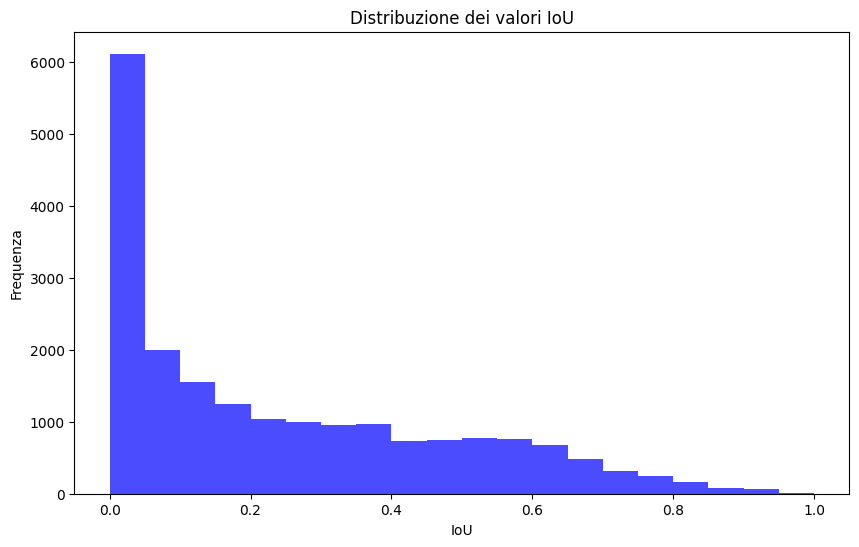

In [57]:
# Crea l'istogramma dei valori IoU
create_iou_histogram(iou_values, bins=20, range=(0, 1))

In [58]:
print(ignored_count)

467911


In [71]:
def analyze_regions(file_path):
    """
    Analizza un file JSON per ottenere il numero di regioni e le occorrenze dei category_id.

    :param file_path: Percorso al file JSON contenente le annotazioni.
    :return: Tupla contenente il numero di regioni e un dizionario con le occorrenze dei category_id.
    """
    # Carica il file JSON
    data = load_json(file_path)

    # Conta il numero di regioni
    num_regioni = len(data)
    
    # Ottieni le occorrenze dei category_id
    category_ids = [entry['category_id'] for entry in data]
    category_counts = Counter(category_ids)

    # Ordina le occorrenze per ID di categoria
    sorted_category_counts = dict(sorted(category_counts.items()))

    return num_regioni, sorted_category_counts

In [72]:
num_regioni, category_counts = analyze_regions(actproposals_json)
print(f"Numero di regioni: {num_regioni}")
print("Occorrenze dei category_id:", category_counts)

Numero di regioni: 6873
Occorrenze dei category_id: {1: 971, 2: 277, 5: 14, 6: 2241, 7: 15, 8: 8, 9: 6, 11: 3341}


# Positive Region Proposals with mAP

In [ ]:
ignored_count = 0  # Contatore globale per le regioni ignorate

def calculate_iou(bb1, bb2):
    global ignored_count  # Accedi alla variabile globale del contatore

    try:
        # Assicurati che le dimensioni siano corrette
        assert bb1['x1'] < bb1['x2']
        assert bb1['y1'] < bb1['y2']
        assert bb2['x1'] < bb2['x2']
        assert bb2['y1'] < bb2['y2']
    except AssertionError:
        # Se si verifica un errore, incrementa il contatore delle regioni ignorate
        ignored_count += 1
        return 0.0  # Restituisci 0.0 per l'IoU in caso di errore (nessuna sovrapposizione)

    # Calcola le dimensioni dell'area comune tra i due box
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    # Se non c'è sovrapposizione, restituisci 0 come area di intersezione
    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # Calcola l'area di intersezione
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    # Calcola le aree individuali dei due bounding box
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    
    # Calcola l'area dell'unione
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)

    # Verifica che l'IoU sia nel range corretto
    assert iou >= 0.0
    assert iou <= 1.0

    return iou

In [ ]:
def assign_labels_with_map(proposals, annotations, map_threshold, categories):
    """
    Assegna etichette alle regioni proposte basandosi sulle annotations utilizzando mAP.

    Parameters:
        proposals (list): Lista delle regioni proposte per un'immagine.
        annotations (list): Lista dei bounding box annotati con etichette.
        map_threshold (float): Soglia mAP per considerare una corrispondenza positiva.
        categories (dict): Dizionario di mapping category_id -> nome categoria.

    Returns:
        list: Lista delle proposte con le etichette assegnate.
    """
    labeled_proposals = []

    for proposal in proposals:
        best_iou = 0
        best_annotation = None

        for annotation in annotations:
            bbox = annotation['bbox']
            annotation_bbox_x = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]  # Conversione in [x, y, x+w, y+h]
            annotation_bbox = [float(value) for value in annotation_bbox_x]
            
            # Calcola l'IoU
            iou = calculate_iou(proposal['coordinates'], annotation_bbox)
            if iou > best_iou:
                best_iou = iou
                best_annotation = annotation

        if best_iou >= map_threshold and best_annotation:
            labeled_proposals.append({
                'proposal_id': proposal['proposal_id'],
                'coordinates': proposal['coordinates'],
                'label': categories.get(best_annotation['category_id'], 'unknown'),
                'iou': best_iou
            })
        else:
            labeled_proposals.append({
                'proposal_id': proposal['proposal_id'],
                'coordinates': proposal['coordinates'],
                'label': 'background',  # Classe "sfondo"
                'iou': best_iou
            })

    return labeled_proposals


In [ ]:
def calculate_map(results):
    """
    Calcola la Mean Average Precision (mAP) sui risultati etichettati.

    Parameters:
        results (list): Lista di tutte le proposte etichettate.

    Returns:
        float: Valore mAP.
    """
    ap_per_class = {}

    for result in results:
        for proposal in result['labeled_proposals']:
            label = proposal['label']
            if label == 'background':
                continue

            if label not in ap_per_class:
                ap_per_class[label] = {'precision': [], 'recall': []}

            # Placeholder per precisione e richiamo (da calcolare separatamente)
            ap_per_class[label]['precision'].append(proposal.get('precision', 1))
            ap_per_class[label]['recall'].append(proposal.get('recall', 1))

    mean_ap = 0
    num_classes = len(ap_per_class)

    for label, metrics in ap_per_class.items():
        sorted_indices = sorted(range(len(metrics['recall'])), key=lambda i: metrics['recall'][i])
        precisions = [metrics['precision'][i] for i in sorted_indices]
        recalls = [metrics['recall'][i] for i in sorted_indices]

        ap = 0
        for i in range(1, len(recalls)):
            ap += (recalls[i] - recalls[i - 1]) * precisions[i]

        mean_ap += ap

    return mean_ap / num_classes if num_classes > 0 else 0

In [ ]:
def process_images_with_map(region_file, annotation_file, output_file):
    """
    Processa tutte le immagini, collega le regioni proposte con le annotations e calcola la mAP.

    Parameters:
        region_file (str): Path al file JSON con le regioni proposte.
        annotation_file (str): Path al file JSON con le annotations.
        output_file (str): Path al file JSON di output.
    """
    # Carica i file JSON
    regions_data = load_json(region_file)
    coco_data = load_json(annotation_file)

    # Prepara le categorie
    categories = {}
    for cat in coco_data['categories']:
        cat_id, cat_name = list(cat.items())[0]
        categories[int(cat_id)] = cat_name

    # Prepara le annotations
    annotations_by_image = {}
    for annotation in coco_data['annotations']:
        img_id = annotation['image_id']
        if img_id not in annotations_by_image:
            annotations_by_image[img_id] = []
        # Mantenere il formato bbox originale, senza conversione qui
        annotations_by_image[img_id].append({
            "bbox": annotation["bbox"],  # Mantieni il bbox nel formato [x, y, w, h]
            "category_id": annotation['category_id']
        })

    results = []

    for image_data in tqdm(regions_data, desc="Processing Images"):
        image_id = image_data['image_id']
        proposals = image_data['proposals']

        # Trova le annotations corrispondenti all'immagine corrente
        annotations = annotations_by_image.get(image_id, [])

        # Calcola la soglia mAP dinamica basata sul numero di annotations
        map_threshold = 0.5 if len(annotations) == 0 else min(0.5 + 0.05 * (len(annotations) - 1), 0.95)

        # Associa le etichette alle proposte
        labeled_proposals = assign_labels_with_map(proposals, annotations, map_threshold, categories)

        # Aggiungi al risultato
        results.append({
            'image_id': image_id,
            'file_name': image_data['file_name'],
            'labeled_proposals': labeled_proposals
        })

    # Calcola la mAP complessiva
    mean_ap = calculate_map(results)

    # Salva i risultati in un file JSON
    with open(output_file, 'w') as f:
        json.dump({"results": results, "mean_ap": mean_ap}, f, indent=4)


In [ ]:
process_images_with_map('/kaggle/input/regions/proposals.json', coco_json_pth, actproposals_json)

# Splitting

In [ ]:
# Percorso del file JSON e del percorso base
input_json_path = "/kaggle/input/activeregion-xviewdataset/activeregion-xview-dataset/active_regions.json"

# Carica il dataset dal JSON
data = load_json(input_json_path)

# Converti in DataFrame per una gestione più comoda
df = pd.DataFrame(data)

# Estrai il nome del file dal campo 'saved_path'
df["file_name"] = df["saved_path"].apply(lambda x: os.path.basename(x))

# Aggiungi il percorso base al campo 'saved_path'
df["saved_path"] = df["file_name"].apply(lambda x: str(act_reg_folder / x))

# Estrai i dati e le etichette
X = df.index  # Indici delle righe
y = df["category_id"]  # Etichetta per stratificazione

# Step 1: Train + Val/Test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Step 2: Val/Test split
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Creazione dei dataset finali
train_data = df.loc[X_train]
val_data = df.loc[X_val]
test_data = df.loc[X_test]

# Salva i dataset in nuovi file JSON
train_data.to_json("train.json", orient="records", lines=False)
val_data.to_json("val.json", orient="records", lines=False)
test_data.to_json("test.json", orient="records", lines=False)

print("Splitting completato. File salvati: train.json, val.json, test.json.")

## Custom Dataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, json_file, transform=None):
        """
        Inizializza il dataset.

        :param json_file: Percorso del file JSON contenente le informazioni sulle regioni.
        :param transform: Trasformazioni da applicare alle immagini. Se non fornito, vengono usate trasformazioni di default.
        """
        # Carica il file JSON
        self.data = load_json(json_file)
        
        # Trasformazioni di default se non vengono fornite
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),         # Ridimensiona l'immagine a 224x224
            transforms.ToTensor()                 # Converte l'immagine in un tensore
            #transforms.Normalize(                  # Normalizzazione con valori di ImageNet
            #    mean=[0.485, 0.456, 0.406], 
            #    std=[0.229, 0.224, 0.225]
            #)
        ])  

    def __len__(self):
        """Restituisce il numero totale di immagini/proposte nel dataset."""
        return len(self.data)

    def __getitem__(self, idx):
        """Restituisce un esempio (immagine e etichetta) per l'addestramento."""
        # Carica l'esempio dal file JSON
        sample = self.data[idx]
        
        # Carica l'immagine
        image = Image.open(sample["saved_path"]).convert("RGB")
        
        # Etichetta della categoria
        label = sample["category_id"]  # Categoria della proposta

        # Applica le trasformazioni
        image = self.transform(image)
        
        return image, label

In [ ]:
test_ds = CustomDataset(test_path)
train_ds = CustomDataset(train_path)
val_ds = CustomDataset(val_path)

TrainLoader = DataLoader(train_ds, batch_size=64, shuffle=True)
ValLoader = DataLoader(val_ds, batch_size=64, shuffle=False)
TestLoader = DataLoader(test_ds, batch_size=64, shuffle=False)

# Feature Extraction

In [ ]:
class AlexNet(nn.Module):

    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self._output_num = num_classes

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
     
        self.drop8 = nn.Dropout()
        self.fn8 = nn.Linear(256 * 6 * 6, 4096)
        self.active8 = nn.ReLU(inplace=True)
        
        self.drop9 = nn.Dropout()
        self.fn9 = nn.Linear(4096, 4096)
        self.active9 = nn.ReLU(inplace=True)
        
        self.fn10 = nn.Linear(4096, self._output_num)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        
        x = self.drop8(x)
        x = self.fn8(x)
        x = self.active8(x)

        x = self.drop9(x)
        x = self.fn9(x)
        
        feature = self.active9(x)  
        #final = func.sigmoid(self.fn10(feature))
        final = self.fn10(feature)

        return feature, final

In [ ]:
num_classes = 12 #11 classi + sfondo
net = AlexNet(num_classes)

In [ ]:
print(net)

In [ ]:
def plot_loss(train_losses, val_losses):
    """
    Funzione per fare il plot della funzione di loss durante il training e la validazione.

    :param train_losses: Lista delle perdite durante il training.
    :param val_losses: Lista delle perdite durante la validazione.
    """
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label="Train Loss", color="blue", linestyle='-', marker='o')
    plt.plot(epochs, val_losses, label="Validation Loss", color="red", linestyle='-', marker='x')
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def compute_class_weights(train_loader, num_classes=12, background_weight=2.0):
    """
    Calcola i pesi per ciascuna classe nel dataset in base alla frequenza delle etichette,
    includendo un peso per la classe "sfondo" (ID=11) che potrebbe non essere presente nei dati.

    :param train_loader: DataLoader per il training set.
    :param num_classes: Numero totale di classi nel dataset (incluso lo sfondo).
    :param background_weight: Peso assegnato alla classe "sfondo" (ID=11).
    :return: Tensor dei pesi per ciascuna classe.
    """
    # Estrai tutte le etichette dal dataset nel train_loader
    all_labels = []
    for _, labels in tqdm(train_loader, desc="Estrazione etichette", leave=False):
        all_labels.extend(labels.numpy())  # Estrae le etichette dalle immagini

    # Conta le occorrenze di ciascuna classe
    class_counts = Counter(all_labels)
    
    # Calcola il peso per ogni classe (inversamente proporzionale alla frequenza)
    total_samples = len(all_labels)
    class_weights = {class_id: total_samples / count for class_id, count in class_counts.items()}
    
    # Normalizza i pesi (in modo che il peso massimo sia 1)
    max_weight = max(class_weights.values())
    normalized_weights = {class_id: weight / max_weight for class_id, weight in class_weights.items()}
    
    # Aggiungi un peso elevato per la classe sfondo (ID=11)
    normalized_weights[11] = background_weight  # Assegna un peso maggiore alla classe sfondo
    
    # Crea un tensor dei pesi, dove ogni peso corrisponde alla classe
    weights = torch.tensor([normalized_weights.get(i, 1.0) for i in range(num_classes)], dtype=torch.float32)
    
    return weights

In [ ]:
def train_model(net, train_loader, val_loader, criterion, optimizer, device, epochs, path_min_loss, class_weights):
    """
    Funzione per addestrare il modello con pesi per classi sbilanciate.

    :param net: Modello da addestrare.
    :param train_loader: DataLoader per il training set.
    :param val_loader: DataLoader per il validation set.
    :param criterion: Funzione di loss.
    :param optimizer: Ottimizzatore.
    :param device: Dispositivo (CPU o GPU).
    :param epochs: Numero di epoche di training.
    :param path_min_loss: Percorso per salvare il modello con la minore loss di validazione.
    """
    min_val_loss = float('inf')

    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

    # Liste per registrare le perdite durante il training e la validazione
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        net.train()  # Modalità training
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        # Barra di avanzamento per il training
        train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training", leave=False)

        for images, labels in train_progress:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            _, outputs = net(images)

            # Calcolo della loss pesata
            loss = criterion(outputs, labels)

            # Backward pass e aggiornamento pesi
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Statistiche
            train_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

            # Aggiorna la barra di avanzamento con la loss corrente
            train_progress.set_postfix(loss=loss.item(), accuracy=100. * correct_train / total_train)

        avg_train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = 100. * correct_train / total_train
        train_losses.append(avg_train_loss)  # Aggiungi il valore di train_loss

        # Validazione
        net.eval()  # Modalità validazione
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        # Barra di avanzamento per la validazione
        val_progress = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation", leave=False)

        with torch.no_grad():
            for images, labels in val_progress:
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                _, outputs = net(images)

                # Calcolo della loss
                loss = criterion(outputs, labels)

                # Statistiche
                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                total_val += labels.size(0)
                correct_val += predicted.eq(labels).sum().item()

                # Aggiorna la barra di avanzamento con la loss e accuracy
                val_progress.set_postfix(loss=loss.item(), accuracy=100. * correct_val / total_val)

        avg_val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = 100. * correct_val / total_val
        val_losses.append(avg_val_loss)  # Aggiungi il valore di val_loss

        # Salva il modello con la loss di validazione più bassa
        if avg_val_loss < min_val_loss:
            print(f"Salvataggio del miglior modello: Val Loss migliorata da {min_val_loss:.4f} a {avg_val_loss:.4f}")
            min_val_loss = avg_val_loss
            torch.save(net.state_dict(), path_min_loss)

        # Stampa statistiche per epoca
        print(f"Epoch [{epoch + 1}/{epochs}]")
        print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    print("Training completato!")

    # Chiamata alla funzione per tracciare il grafico
    plot_loss(train_losses, val_losses)

In [ ]:
def test_model(net, test_loader, criterion, device, path_min_loss):
    """
    Funzione per testare il modello.

    :param net: Modello da testare.
    :param test_loader: DataLoader per il test set.
    :param criterion: Funzione di loss.
    :param device: Dispositivo (CPU o GPU).
    :param path_min_loss: Percorso del modello salvato.
    """
    # Carica il miglior modello salvato
    net.load_state_dict(torch.load(path_min_loss))
    net.eval()

    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            _, outputs = net(images)

            # Calcolo della loss
            loss = criterion(outputs, labels)

            # Statistiche
            test_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()

    avg_test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = 100. * correct_test / total_test

    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


In [ ]:
# Calcola i pesi per ogni classe dal train_loader
class_weights = compute_class_weights(TrainLoader)
print(class_weights)

In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
epochs = 10
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

device = torch.device("cuda")

net = net.to(device)
criterion = criterion.to(device)

path_min_loss = '/kaggle/working/AlexNet.pth'

train_model(
    net=net,
    train_loader=TrainLoader,
    val_loader=ValLoader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=epochs,
    path_min_loss=path_min_loss,
    class_weights=class_weights
)

In [ ]:
test_model(
    net=net,
    test_loader=TestLoader,
    criterion=criterion,
    device=device,
    path_min_loss=path_min_loss
)

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Funzione per calcolare e visualizzare la matrice di confusione.

    :param y_true: Etichette reali
    :param y_pred: Etichette predette dal modello
    :param class_names: Nomi delle classi
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Durante la fase di validazione o test, calcola la matrice di confusione
def validate_model(net, val_loader, device, class_names):
    net.eval()  # Modalità di valutazione
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            _, outputs = net(images)
            
            # Predizioni
            _, predicted = outputs.max(1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    # Visualizza la matrice di confusione
    plot_confusion_matrix(all_labels, all_preds, class_names)

# Esempio di come chiamare la funzione
class_names = ['Classe 0', 'Classe 1', 'Classe 2', 'Classe 3', 'Classe 4', 'Classe 5', 'Classe 6', 'Classe 7', 'Classe 8', 'Classe 9', 'Classe 10']
validate_model(net, ValLoader, device, class_names)